# Taking short walks up and down slopes in Julia

In [13]:
using DynLoco
using Plots
default(grid=false) # no grid on plots

## Short walks of different distances
Take walks of varying distances, and show how the optimal trajectory is to have a bell-shaped
velocity profile, with peak speed that increases with distance up to about 12 steps.
The cost function is total work, plus a linear cost of time with coefficient ctime.

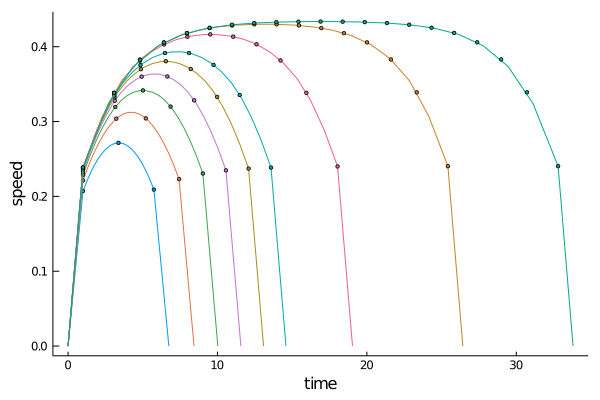


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



In [2]:
wstar4 = findgait(WalkRW2l(α=0.35), target=:speed=>0.3, varying=:P)
ctime = 0.02 # cost of time, to encourage hurrying
tchange = 1
p = plot()
walksteps = [2, 3, 4, 5, 6, 7, 10, 15, 20] # take walks of this # of steps
results = Array{MultiStepResults,1}(undef,0) # store each optimization result here
for (i,nsteps) in enumerate(walksteps)
    result = optwalktime(wstar4, nsteps, ctime=ctime) # optimize with a cost of time
    plotvees!(result, tchange=tchange, color=i, rampuporder=1, markersize=2) # plot instantaneous speed vs. time
    push!(results, result) # add this optimization to results array
end
Plots.display(p) # instantaneous speed vs. distance profiles

## Short walks: Peak speed vs. distances

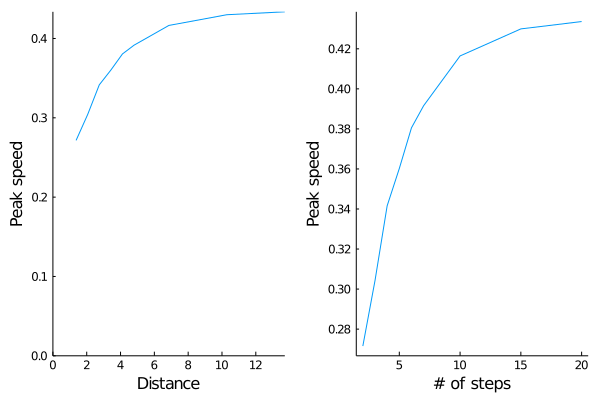

In [3]:
peakspeeds = [maximum(result.steps.vm) for result in results]
distances = [sum(result.steps.steplength) for result in results]
p1 = plot(distances, peakspeeds, xlabel="Distance", ylabel="Peak speed", xlims=(0,Inf), ylims=(0,Inf))
p2 = plot(walksteps, peakspeeds, xlabel="# of steps", ylabel="Peak speed")
plot(p1, p2, layout = (1,2), legend=false)

## Short walks: Time to walk a distance
A fairly linear increase in time to walk a distance, but with a slight curved toe-in

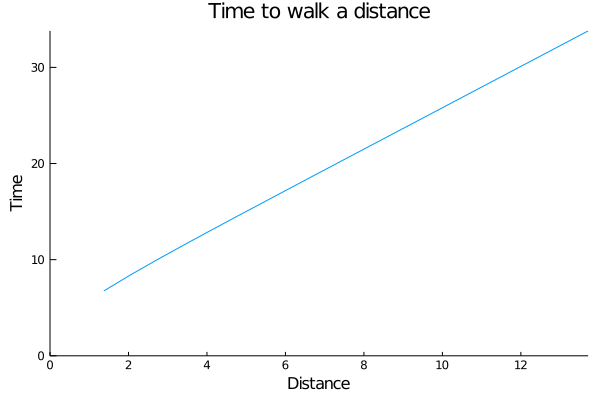

In [4]:
timetowalk = [result.totaltime+2*tchange for result in results]
plot(distances, timetowalk, xlims=(0,Inf), ylims=(0,Inf),
    xguide="Distance", yguide="Time", title="Time to walk a distance", label=nothing)

## Short walks: Up and down slopes
Compare walking uphill, downhill, and level, for a fixed number of steps, and including
optimized time. The results show uphill walking is skewed to fast speed-up at beginning,
slow coasting toward end. Downhill is skewed for slow speed-up aided by gravity, and
abrupt end.
`optwalktime` is an optimization for a given number of steps, with a `ctime` cost.

Make plots comparing up, level, down for various numbers of steps

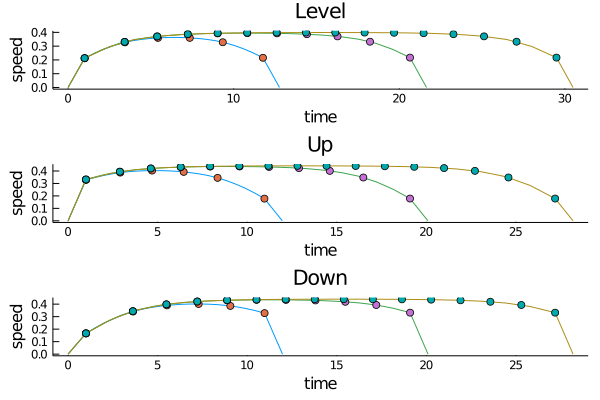

In [5]:
wstar4s = findgait(WalkRW2l(α=0.4,safety=true), target=:speed=>0.4, varying=:P)
myslope = 0.08
p = plot(layout=(3,1))
for (i,nsteps) = enumerate([5, 10, 15])
    resultlevel = optwalktime(wstar4s, nsteps, ctime = ctime)
    plotvees!(p[1],resultlevel, tchange=tchange, title="Level", rampuporder=1) # special function to include ramp-up in speed

    # walk up a 10% slope
    resultup = optwalktime(wstar4s, nsteps, ctime = ctime, δs=fill(myslope, nsteps))
    plotvees!(p[2],resultup, tchange=tchange, title="Up", rampuporder=1)

    # Walk down a slope
    resultdown = optwalktime(wstar4s, nsteps, ctime = ctime, δs=fill(-myslope, nsteps))
    plotvees!(p[3],resultdown, tchange=1, title="Down", rampuporder=1)
end
Plots.display(p)

## Short walks: Varying slope angles
The steeper, the more skewed the speed profile

Make plots comparing up, level, down for various numbers of steps

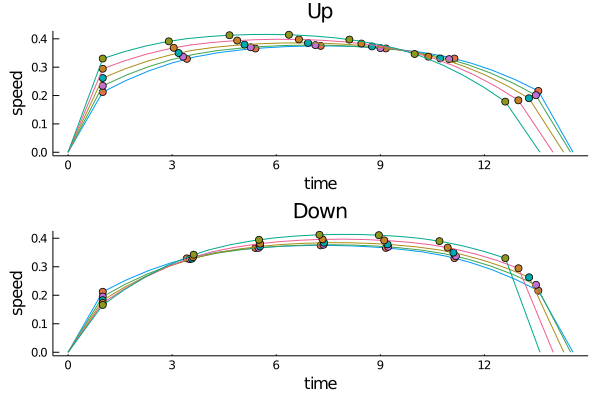

In [6]:
wstar4s = findgait(WalkRW2l(α=0.4,safety=true), target=:speed=>0.4, varying=:P)
myslopes = 0:0.02:0.08
p = plot(layout=(2,1))
nsteps = 6
startv = wstar4.vm
for slope in myslopes
    # walk up a slope
    resultup = optwalktime(wstar4s, nsteps, ctime = ctime, δs=fill(slope, nsteps))
    plotvees!(p[1],resultup, tchange=1, title="Up", rampuporder=1)
    startv = [resultup.vm0;resultup.steps.vm]

    # Walk down a slope
    resultdown = optwalktime(wstar4s, nsteps, ctime = ctime, δs=fill(-slope, nsteps))
    plotvees!(p[2],resultdown, tchange=1, title="Down", rampuporder=1)
end
Plots.display(p)

## Short walks: Varying step lengths
Shorter steps will yield a more plateaued speed profile.
Longer steps will reach more of a rounded profile with bigger range of speeds.
(This optimization allows for faster speeds at short steps, due to a lack of
swing leg cost. Humans will probably not walk faster with short steps.)

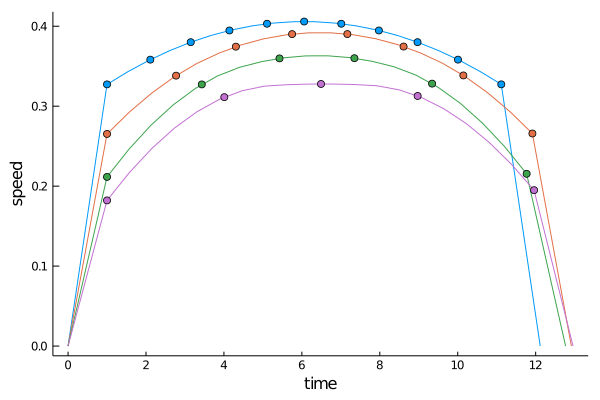

In [7]:
stepfreq = onestep(wstar4).stepfrequency
αs = [0.2, 0.3, 0.4, 0.5]
nominalsteps = 6
totaldistance = 6*onestep(wstar4).steplength # walk a similar distance for all
steplengths = 2*wstar4.L .* sin.(αs)
p = plot()
results = Array{MultiStepResults,1}(undef,0) # store each optimization result here
for (i,α) in enumerate(αs)
    nsteps = Int(round(totaldistance/steplengths[i]))
    w = findgait(WalkRW2l(wstar4,α=α,safety=true), target=:stepfrequency=>stepfreq, varying=:P)
    result = optwalktime(w, nsteps, ctime=ctime) # optimize with a cost of time
    plotvees!(result, tchange=1, color=i, rampuporder=1) # plot instantaneous speed vs. time
    push!(results, result) # add this optimization to results array
end
Plots.display(p) # instantaneous speed vs. distance profiles

## Short walks: Compare trapezoid cruising against short walk
Another way to walk a short distance with cruise speed, "trapezoid" velocity
Start from a boundaryvel, do boundary work to get a certain speed
then continue with a ramp up in speed, then stay at a cruise speed
and then ramp down and hit another boundaryvel
v[1] is the mid-stance velocity where you have say Naccel steps to get to cruise
 speed up    cruise cruise cruise cruise   slow down
0 v[1] v[2]  v[Naccel+1] to v[Naccel + N]  v[end-2] v[end-1] v[end]

trapezoid cost = 0.20868784294084677   optimal cost = 0.18726183810087355


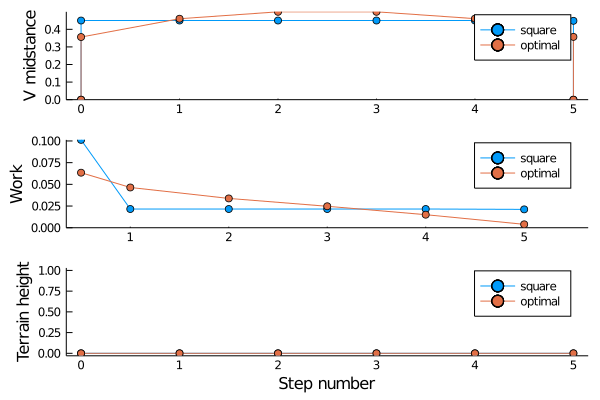

In [8]:
using JuMP, Ipopt
boundaryvels = (0.,0.) # actually the code below all assumes 0 boundary speed

Ncruise = 5 # how many steps of cruising
Naccel = 0  # how many steps of start-up (and again for end)
Nsteps = Naccel*2 + Ncruise
vcruise = 0.45 # cruising speed, always fixed
# linear increase deltavel = vcruise/(Naccel+1)
# constraint v[i=1..Naccel] = deltavel*i
deltavel = vcruise / (Naccel+1) # assuming starting from zero speed
velstart = [deltavel*i for i in 1:Naccel] # ramp up in speed
velcruise = [vcruise for i in 1:Ncruise]
velend = [deltavel*(Naccel+1-i) for i in 1:Naccel]
vels = [velstart; velcruise; velend]
# constraint v[Naccel+1 ... Naccel+N] == vcruise
# constraint v[Naccel+N+(1..Naccel)] == deltavel*(Naccel+1-i)
# solve for P that produces it, time will be an outcome
w = WalkRW2l(wstar4, safety=true)
optsteps = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))
@variable(optsteps, P[1:Nsteps]>=0, start=w.P) # JuMP variables P

# Constraints
register(optsteps, :onestepv, 3, # velocity after a step
    (v,P,δ)->onestep(w,P=P,vm=v, δangle=δ).vm, autodiff=true) # output vm
for i = 1:Nsteps-1  # step dynamics
    @NLconstraint(optsteps, vels[i+1]==onestepv(vels[i],P[i],0.)) # put delta here
end

# leave out the objective, because we are fully prescribing everything with constraints
optimize!(optsteps)
if termination_status(optsteps) == MOI.LOCALLY_SOLVED || termination_status(optsteps) == MOI.OPTIMAL
    optimal_solution = Ps=value.(P)
else
    error("The model was not solved correctly.")
    println(termination_status(optsteps))
end
trapezoidresults=multistep(WalkRW2l(w,vm=vels[1]), Ps=optimal_solution, boundaryvels=(0.,0.),
    extracost = 1/2*(vels[1]^2 - boundaryvels[1]^2) )

# verify with multistep
multistepplot(trapezoidresults,plotwork=true, label="square")

# If you just want to do square wave in speed, it costs a lot of initial push-off
# so let's compare with walking the same number of steps and same amount of time
optresults=optwalk(w, Ncruise, boundaryvels=(0,0),totaltime=trapezoidresults.totaltime  )
println("trapezoid cost = ", trapezoidresults.totalcost, "   optimal cost = ", optresults.totalcost)
# It's definitely more expensive to use the square wave
multistepplot!(optresults,plotwork=true,label="optimal")

#### Trajectory for short walks
To be continued

## Brachistokuo Ramp

Optimal slope and walk with ramp
Compare walking ramp and flat in same amount of time, for three different times

ramp total cost = 0.24969756338511045
flat total cost = 0.2674528388745012


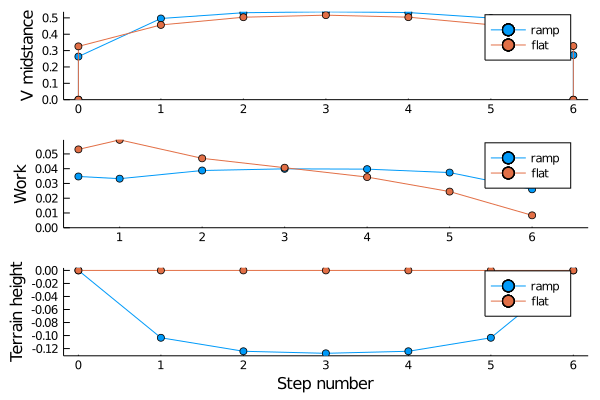

In [9]:
wstar = findgait(WalkRW2l(α=0.4,safety=true), target=:speed=>0.4, varying=:P)
N = 6
walktime = N * onestep(wstar).tf *0.82 # meant to be a brisk walk
walkdistance = N * onestep(wstar).steplength
rampresult = optwalkslope(wstar, N, boundaryvels = (0., 0.), symmetric = true,
    totaltime = walktime)
p = multistepplot(rampresult; plotwork=true, label="ramp")
println("ramp total cost = ", rampresult.totalcost)
flatresult = optwalk(wstar, N, boundaryvels = (0., 0.),
    totaltime = rampresult.totaltime, δ = zeros(6))
println("flat total cost = ", flatresult.totalcost)
multistepplot!(flatresult; plotwork=true, label="flat")
# optionally, try a reversed ramp and see if it's higher cost still
#concaveresult = optwalk(wstar, 6, boundaryvels = (0.,0.), boundarywork=true,
#    totaltime = rampresult.totaltime, δ = -rampresult.δangles)
#multistepplot!(concaveresult; plotwork=true)

## Brachistokuo ramp: Compute the cost for different speeds

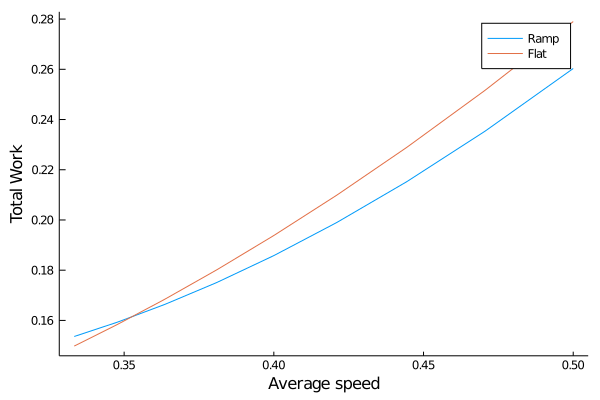

In [11]:
walktimes = (0.8:0.05:1.2) * N*onestep(wstar).tf
rampresults = Array{MultiStepResults,1}(undef, length(walktimes))
flatresults = Array{MultiStepResults,1}(undef, length(walktimes))
for (i,walktime) in enumerate(walktimes)
    rampresults[i] = optwalk(wstar, N, boundaryvels = (0.,0.),
        totaltime = walktime, δ = rampresult.δangles)
    flatresults[i] = optwalk(wstar, N, boundaryvels = (0.,0.),
        totaltime = walktime, δ = zeros(N))
end
# plot totalcost vs average speed
plot(walkdistance ./ walktimes, [getfield.(rampresults, :totalcost), getfield.(flatresults, :totalcost)],
    xlabel="Average speed", ylabel="Total Work", labels=["Ramp" "Flat"])

## Brachistokuo ramp: Plot the ramp to scale

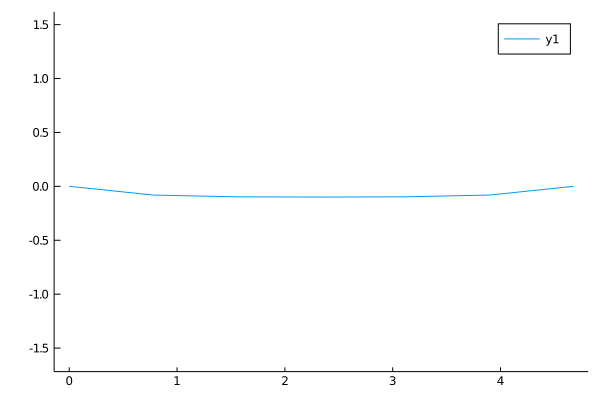

In [12]:
plot(onestep(wstar).steplength .* (0:6),cumsum(tan.([0;rampresult.δangles]).*onestep(wstar).steplength),
    aspect_ratio=1)